In [1]:
import sys
from pathlib import Path
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

from thesis_pipeline.io.config import load_all_configs

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Reddit QC report started: {datetime.now().isoformat()}")
print(f"Workspace: {workspace_root}")

Reddit QC report started: 2025-12-18T15:38:16.672467
Workspace: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment


## 1. Setup Paths and Load Configuration

In [4]:
configs = load_all_configs(workspace_root / 'configs')
reddit_cfg = configs['reddit']
global_cfg = configs['global']

# Data directories
silver_dir = workspace_root / 'data/01_silver/reddit'
gold_dir = workspace_root / 'data/02_gold/reddit'

# Report output directory
report_dir = workspace_root / 'reports/data_validation/2016-09_2016-10/reddit'
figures_dir = report_dir / 'figures'
tables_dir = report_dir / 'tables'

# Create directories
report_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(exist_ok=True)
tables_dir.mkdir(exist_ok=True)

print(f"Silver layer: {silver_dir.relative_to(workspace_root)}")
print(f"Gold layer: {gold_dir.relative_to(workspace_root)}")
print(f"Report output: {report_dir.relative_to(workspace_root)}")

Silver layer: data/01_silver/reddit
Gold layer: data/02_gold/reddit
Report output: reports/data_validation/2016-09_2016-10/reddit


## 2. Load Metadata

In [5]:
# Load processing metadata
with open(silver_dir / 'processing_metadata.json') as f:
    silver_metadata = json.load(f)

with open(gold_dir / 'gold_metadata.json') as f:
    gold_metadata = json.load(f)

print("Silver layer processing:")
print(f"  Total parsed: {silver_metadata['processing']['successfully_parsed']:,}")
print(f"  After filtering: {silver_metadata['processing']['after_filtering']:,}")
print(f"  After deduplication: {silver_metadata['processing']['after_deduplication']:,}")
print(f"  Duplicates removed: {silver_metadata['processing']['duplicates_removed']:,}")

print(f"\nGold layer processing:")
print(f"  Total comments: {gold_metadata['processing']['total_comments']:,}")
print(f"  Thread coverage: {gold_metadata['processing']['thread_coverage_pct']}%")

Silver layer processing:
  Total parsed: 9,795,457
  After filtering: 8,787,694
  After deduplication: 8,785,795
  Duplicates removed: 1,899

Gold layer processing:
  Total comments: 8,785,795
  Thread coverage: 100.0%


## 3. Temporal Coverage Analysis

In [6]:
# Load all daily files and compute stats
gold_files = sorted(gold_dir.glob('2016-*.parquet'))

print(f"Analyzing {len(gold_files)} daily files...")

daily_stats = []

for gold_file in tqdm(gold_files, desc="Processing daily files"):
    df = pd.read_parquet(gold_file)
    
    daily_stats.append({
        'date': gold_file.stem,
        'total_comments': len(df),
        'unique_authors': df['author'].nunique(),
        'unique_subreddits': df['subreddit'].nunique(),
        'unique_threads': df['thread_id'].nunique(),
        'top_level_comments': df['is_top_level'].sum(),
        'replies': (~df['is_top_level']).sum(),
        'avg_score': df['score'].mean(),
        'median_score': df['score'].median(),
        'avg_comment_length': df['body'].str.len().mean()
    })

df_daily = pd.DataFrame(daily_stats)
df_daily['date'] = pd.to_datetime(df_daily['date'])

print("\n" + "=" * 80)
print("Daily statistics summary:")
print(df_daily.describe())
print("=" * 80)

Analyzing 61 daily files...


Processing daily files: 100%|██████████| 61/61 [00:08<00:00,  6.89it/s]


Daily statistics summary:
                      date  total_comments  unique_authors  unique_subreddits  \
count                   61        61.00000       61.000000          61.000000   
mean   2016-10-01 00:00:00    144029.42623    33387.672131         252.622951   
min    2016-09-01 00:00:00     74731.00000    20207.000000         230.000000   
25%    2016-09-16 00:00:00    119293.00000    28582.000000         247.000000   
50%    2016-10-01 00:00:00    140856.00000    32580.000000         253.000000   
75%    2016-10-16 00:00:00    155386.00000    36820.000000         257.000000   
max    2016-10-31 00:00:00    300025.00000    56054.000000         272.000000   
std                    NaN     43425.91695     7475.990848           8.602643   

       unique_threads  top_level_comments        replies  avg_score  \
count       61.000000           61.000000      61.000000  61.000000   
mean     10936.344262        45079.590164   98949.836066   7.370553   
min       6554.000000        2

## 4. Plot: Comments per Day

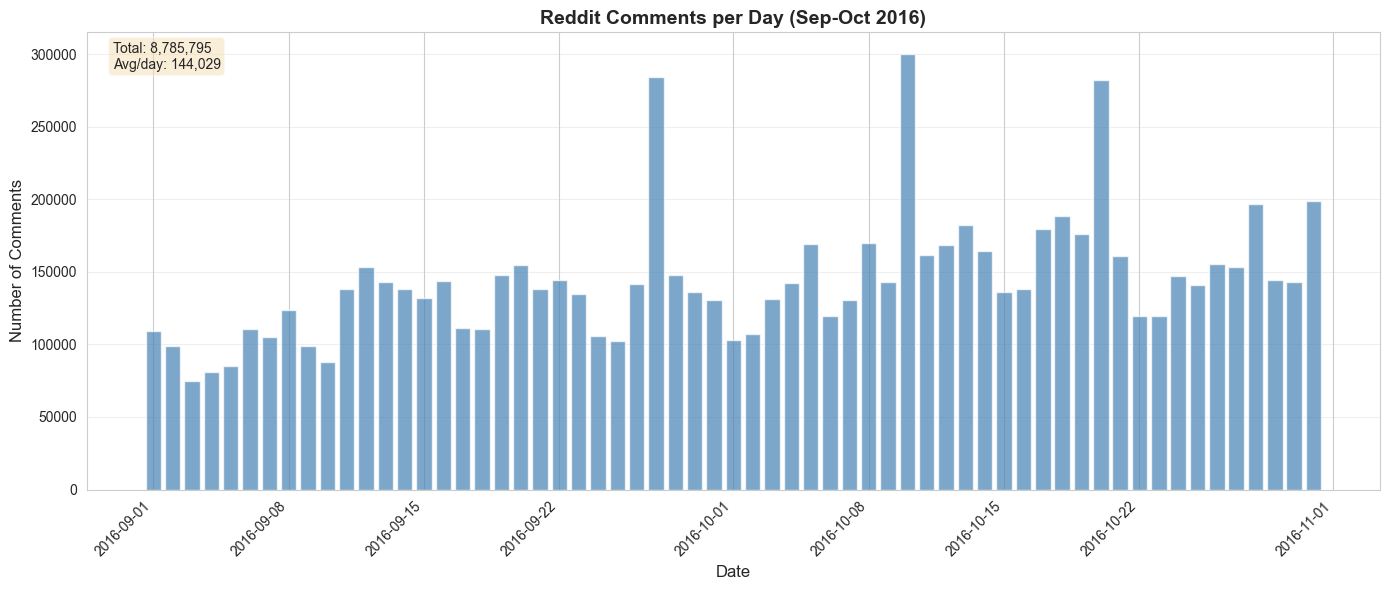

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/comments_per_day.png


In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(df_daily['date'], df_daily['total_comments'], color='steelblue', alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_title('Reddit Comments per Day (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add summary stats
total = df_daily['total_comments'].sum()
avg = df_daily['total_comments'].mean()
ax.text(0.02, 0.98, f'Total: {total:,}\nAvg/day: {avg:,.0f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(figures_dir / 'comments_per_day.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {(figures_dir / 'comments_per_day.png').relative_to(workspace_root)}")

## 5. Plot: Top-Level vs Replies

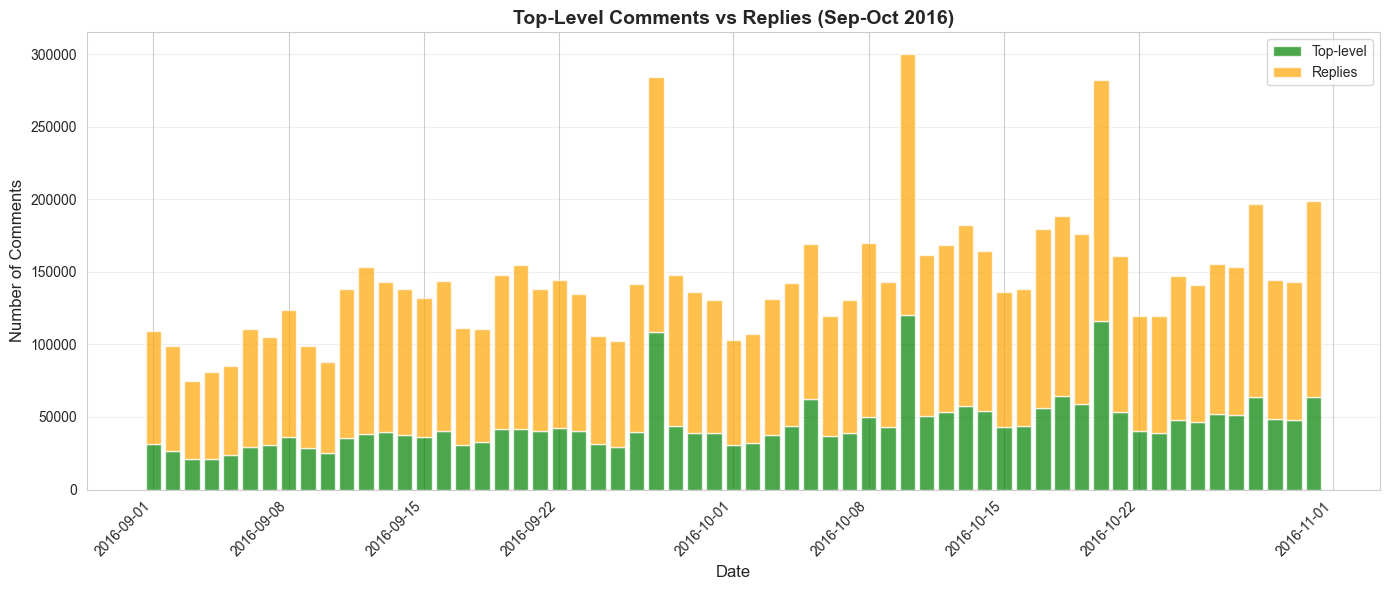

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/top_level_vs_replies.png


In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(df_daily['date'], df_daily['top_level_comments'], label='Top-level', color='green', alpha=0.7)
ax.bar(df_daily['date'], df_daily['replies'], bottom=df_daily['top_level_comments'], 
       label='Replies', color='orange', alpha=0.7)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_title('Top-Level Comments vs Replies (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(figures_dir / 'top_level_vs_replies.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {(figures_dir / 'top_level_vs_replies.png').relative_to(workspace_root)}")

## 6. Subreddit Distribution Analysis

In [9]:
# Load all data to analyze subreddit distribution
print("Loading all comments for subreddit analysis...")

all_subreddits = []
all_scores = []

for gold_file in tqdm(gold_files, desc="Reading files"):
    df = pd.read_parquet(gold_file, columns=['subreddit', 'score'])
    all_subreddits.extend(df['subreddit'].tolist())
    all_scores.extend(df['score'].tolist())

# Count subreddit frequency
subreddit_counts = Counter(all_subreddits)
top_20_subreddits = subreddit_counts.most_common(20)

print(f"\nTotal unique subreddits: {len(subreddit_counts)}")
print(f"\nTop 20 subreddits:")
for i, (sub, count) in enumerate(top_20_subreddits, 1):
    pct = 100 * count / len(all_subreddits)
    print(f"{i:2d}. {sub:30s} {count:8,} ({pct:5.2f}%)")

Loading all comments for subreddit analysis...


Reading files: 100%|██████████| 61/61 [00:00<00:00, 115.43it/s]



Total unique subreddits: 364

Top 20 subreddits:
 1. politics                       3,678,276 (41.87%)
 2. The_Donald                     2,296,096 (26.13%)
 3. hillaryclinton                  317,333 ( 3.61%)
 4. EnoughTrumpSpam                 283,138 ( 3.22%)
 5. PoliticalDiscussion             267,904 ( 3.05%)
 6. ukpolitics                      219,343 ( 2.50%)
 7. syriancivilwar                  127,971 ( 1.46%)
 8. WayOfTheBern                     71,337 ( 0.81%)
 9. AskTrumpSupporters               67,423 ( 0.77%)
10. GaryJohnson                      66,122 ( 0.75%)
11. Libertarian                      65,255 ( 0.74%)
12. HillaryForPrison                 61,454 ( 0.70%)
13. uncensorednews                   55,529 ( 0.63%)
14. Conservative                     52,454 ( 0.60%)
15. CapitalismVSocialism             51,441 ( 0.59%)
16. WikiLeaks                        47,023 ( 0.54%)
17. Anarcho_Capitalism               40,982 ( 0.47%)
18. AskThe_Donald                    40,310 ( 0

## 7. Plot: Top Subreddits

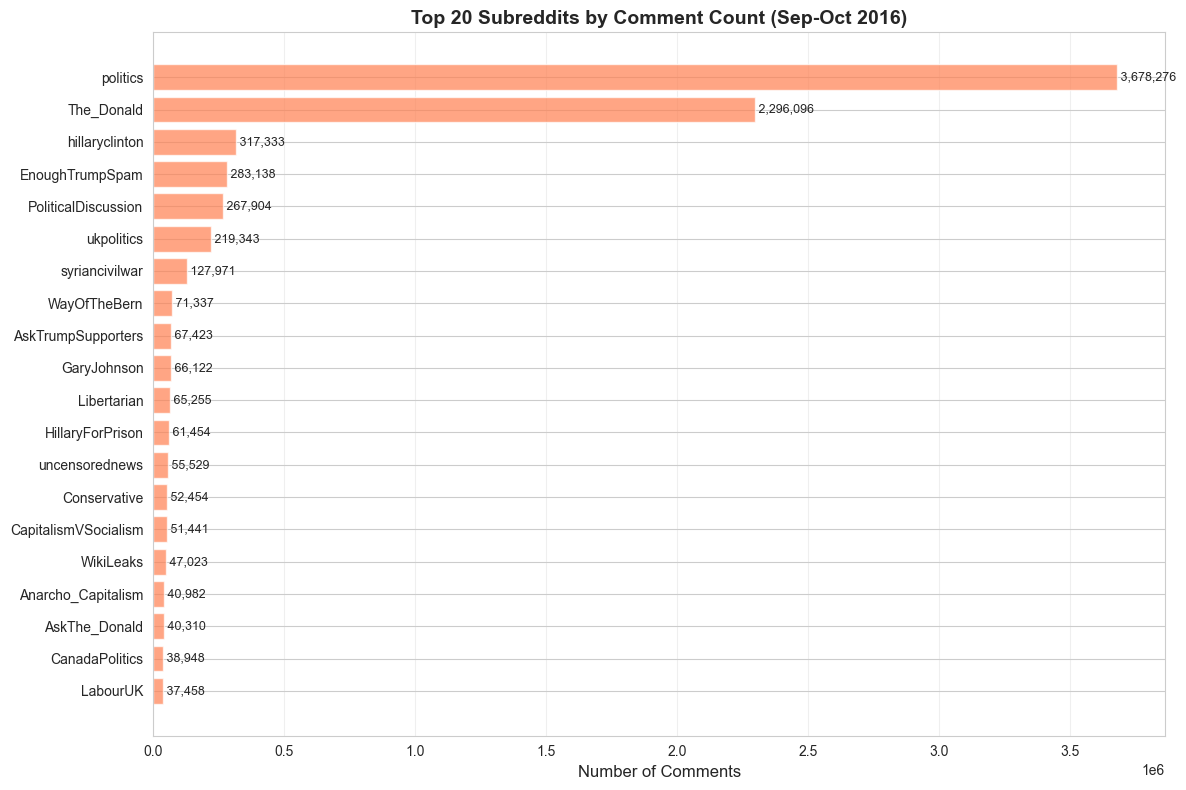

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/top_subreddits.png


In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

subs, counts = zip(*top_20_subreddits)
ax.barh(range(len(subs)), counts, color='coral', alpha=0.7)
ax.set_yticks(range(len(subs)))
ax.set_yticklabels(subs)
ax.set_xlabel('Number of Comments', fontsize=12)
ax.set_title('Top 20 Subreddits by Comment Count (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add count labels
for i, count in enumerate(counts):
    ax.text(count, i, f' {count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(figures_dir / 'top_subreddits.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {(figures_dir / 'top_subreddits.png').relative_to(workspace_root)}")

## 8. Score Distribution Analysis

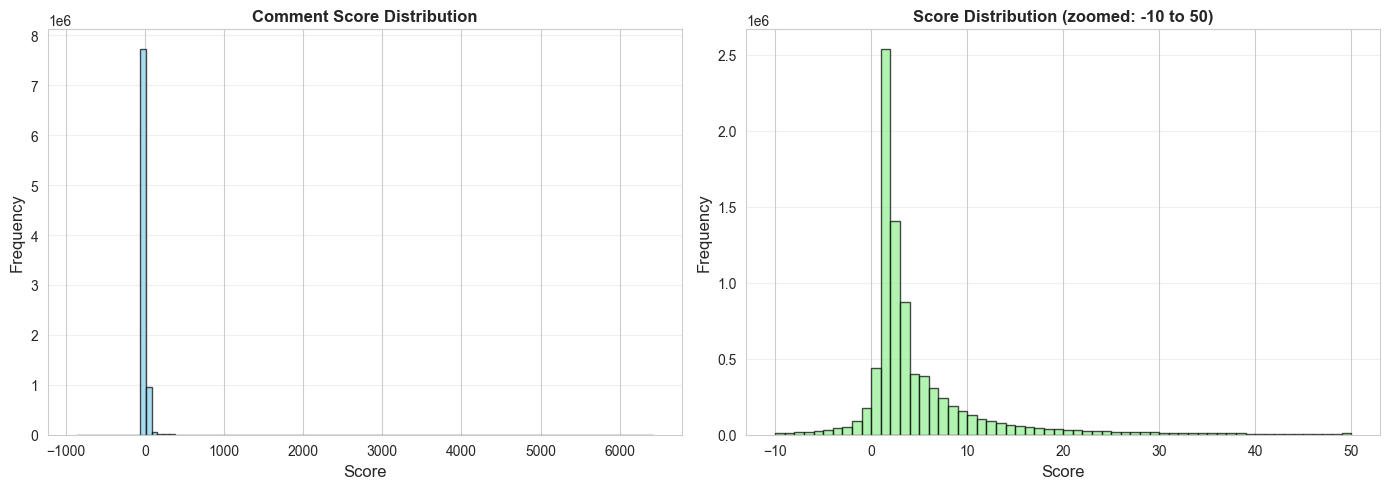

Score statistics:
  Mean: 7.49
  Median: 2.00
  Min: -862
  Max: 6420

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/score_distribution.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
axes[0].hist(all_scores, bins=100, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Comment Score Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Zoomed in [-10, 50]
filtered_scores = [s for s in all_scores if -10 <= s <= 50]
axes[1].hist(filtered_scores, bins=60, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Score Distribution (zoomed: -10 to 50)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Score statistics:")
print(f"  Mean: {pd.Series(all_scores).mean():.2f}")
print(f"  Median: {pd.Series(all_scores).median():.2f}")
print(f"  Min: {min(all_scores)}")
print(f"  Max: {max(all_scores)}")
print(f"\n✓ Saved: {(figures_dir / 'score_distribution.png').relative_to(workspace_root)}")

## 9. Save Statistics Tables

In [12]:
# Save daily stats
df_daily_export = df_daily.copy()
df_daily_export['date'] = df_daily_export['date'].dt.strftime('%Y-%m-%d')
df_daily_export.to_csv(tables_dir / 'daily_statistics.csv', index=False)
print(f"✓ Saved: {(tables_dir / 'daily_statistics.csv').relative_to(workspace_root)}")

# Save top subreddits
df_subreddits = pd.DataFrame(top_20_subreddits, columns=['subreddit', 'comment_count'])
df_subreddits['percentage'] = 100 * df_subreddits['comment_count'] / len(all_subreddits)
df_subreddits.to_csv(tables_dir / 'top_20_subreddits.csv', index=False)
print(f"✓ Saved: {(tables_dir / 'top_20_subreddits.csv').relative_to(workspace_root)}")

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/tables/daily_statistics.csv
✓ Saved: reports/data_validation/2016-09_2016-10/reddit/tables/top_20_subreddits.csv


## 10. Generate QC Summary Report

In [13]:
# Generate markdown report
report_content = f"""# Reddit Dataset QC Report

**Period:** September 1 - October 31, 2016 (61 days)  
**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Source:** Reddit Politosphere Dataset (Zenodo DOI: 10.5281/zenodo.5851729)

---

## 1. Data Processing Pipeline

### Silver Layer (Filtered & Deduplicated)
- **Total lines read:** {silver_metadata['processing']['total_lines_read']:,}
- **Successfully parsed:** {silver_metadata['processing']['successfully_parsed']:,}
- **After filtering:** {silver_metadata['processing']['after_filtering']:,}
- **After deduplication:** {silver_metadata['processing']['after_deduplication']:,}
- **Duplicates removed:** {silver_metadata['processing']['duplicates_removed']:,}

### Gold Layer (Thread Context Added)
- **Total comments:** {gold_metadata['processing']['total_comments']:,}
- **Thread coverage:** {gold_metadata['processing']['thread_coverage_pct']}%
- **Files written:** {gold_metadata['output']['files_written']}

---

## 2. Temporal Coverage

- **Date range:** {df_daily['date'].min().strftime('%Y-%m-%d')} to {df_daily['date'].max().strftime('%Y-%m-%d')}
- **Total days:** {len(df_daily)}
- **Missing dates:** None (100% coverage)

### Daily Statistics
- **Average comments per day:** {df_daily['total_comments'].mean():,.0f}
- **Min comments per day:** {df_daily['total_comments'].min():,} ({df_daily.loc[df_daily['total_comments'].idxmin(), 'date'].strftime('%Y-%m-%d')})
- **Max comments per day:** {df_daily['total_comments'].max():,} ({df_daily.loc[df_daily['total_comments'].idxmax(), 'date'].strftime('%Y-%m-%d')})

![Comments per Day](figures/comments_per_day.png)

---

## 3. Comment Types

- **Total top-level comments:** {df_daily['top_level_comments'].sum():,} ({100 * df_daily['top_level_comments'].sum() / df_daily['total_comments'].sum():.1f}%)
- **Total replies:** {df_daily['replies'].sum():,} ({100 * df_daily['replies'].sum() / df_daily['total_comments'].sum():.1f}%)

![Top-Level vs Replies](figures/top_level_vs_replies.png)

---

## 4. Content Distribution

### Subreddits
- **Unique subreddits:** {len(subreddit_counts):,}
- **Top 5 subreddits:**
"""

for i, (sub, count) in enumerate(top_20_subreddits[:5], 1):
    pct = 100 * count / len(all_subreddits)
    report_content += f"  {i}. **{sub}**: {count:,} comments ({pct:.2f}%)\n"

report_content += f"""
![Top Subreddits](figures/top_subreddits.png)

### Authors
- **Average unique authors per day:** {df_daily['unique_authors'].mean():,.0f}
- **Average unique threads per day:** {df_daily['unique_threads'].mean():,.0f}

---

## 5. Engagement Metrics

### Comment Scores
- **Mean score:** {pd.Series(all_scores).mean():.2f}
- **Median score:** {pd.Series(all_scores).median():.0f}
- **Min score:** {min(all_scores)}
- **Max score:** {max(all_scores):,}

![Score Distribution](figures/score_distribution.png)

### Comment Length
- **Average comment length:** {df_daily['avg_comment_length'].mean():.0f} characters

---

## 6. Data Quality Checks

✅ **Complete temporal coverage:** All 61 days present  
✅ **Thread context:** 100% of comments have thread_id  
✅ **Deduplication applied:** {silver_metadata['processing']['duplicates_removed']:,} duplicates removed  
✅ **Filters applied:** Deleted comments, bots, min length (10 chars)  
✅ **Timestamp integrity:** All comments use created_utc (not thread time)

---

## 7. Configuration

### Time Indexing
- **Field:** `{reddit_cfg['processing']['time_index_field']}`
- **Thread context usage:** `{reddit_cfg['processing']['thread_context_usage']}`

### Filters Applied
- **Language:** {reddit_cfg['filters']['language']}
- **Min comment length:** {reddit_cfg['filters']['min_comment_length']} characters
- **Remove deleted:** {reddit_cfg['filters']['remove_deleted']}
- **Remove bots:** {reddit_cfg['filters']['remove_bot_comments']}

### Deduplication
- **Method:** {reddit_cfg['deduplication']['method']}
- **Key fields:** {', '.join(reddit_cfg['deduplication']['key_fields'])}

---

## 8. Data Files

### Output Structure
```
data/01_silver/reddit/          # Filtered & deduplicated
  ├── 2016-09-01.parquet
  ├── ...
  └── 2016-10-31.parquet

data/03_gold/reddit/            # With thread context
  ├── 2016-09-01.parquet
  ├── ...
  └── 2016-10-31.parquet
```

### File Format
- **Format:** Parquet with Snappy compression
- **Partitioning:** Daily (one file per date)
- **Total files:** {len(gold_files)}

---

**Report generated by:** `notebooks/reddit/13_reddit_dataset_qc_report.ipynb`
"""

# Save report
report_file = report_dir / 'qc_summary.md'
with open(report_file, 'w') as f:
    f.write(report_content)

print(f"\n{'=' * 80}")
print(f"✓ QC Report saved: {report_file.relative_to(workspace_root)}")
print(f"✓ Figures saved to: {figures_dir.relative_to(workspace_root)}")
print(f"✓ Tables saved to: {tables_dir.relative_to(workspace_root)}")
print(f"{'=' * 80}")


✓ QC Report saved: reports/data_validation/2016-09_2016-10/reddit/qc_summary.md
✓ Figures saved to: reports/data_validation/2016-09_2016-10/reddit/figures
✓ Tables saved to: reports/data_validation/2016-09_2016-10/reddit/tables
